# Performance of Batting Order Selection Strategies
Since there are such a vast number of possible batting order permutations, it is not feasible to test all of them. Instead, we will test a few strategies for exploring the space of permutations.

These tests should are be run from batting_order_optimization.py, which will save files in blosc2 format. The notebook is just to load the results and visualize them.

In [2]:
import os

import numpy as np
from matplotlib import pyplot as plt
from tqdm.notebook import tqdm

from src.data.data_loading import load_blosc2, BaseballData, save_blosc2
from src.model.players import Pitcher
from src.model.state import DebugRules, GameState
from src.policy.batting_order_optimization import Random, OneByOne, GreedyHillClimbing, StochasticHillClimbing, ShortTermHillClimbing, GeneticAlgorithm, rules
from src.policy.optimal_policy import PolicySolver
from src.policy.rosters import rosters

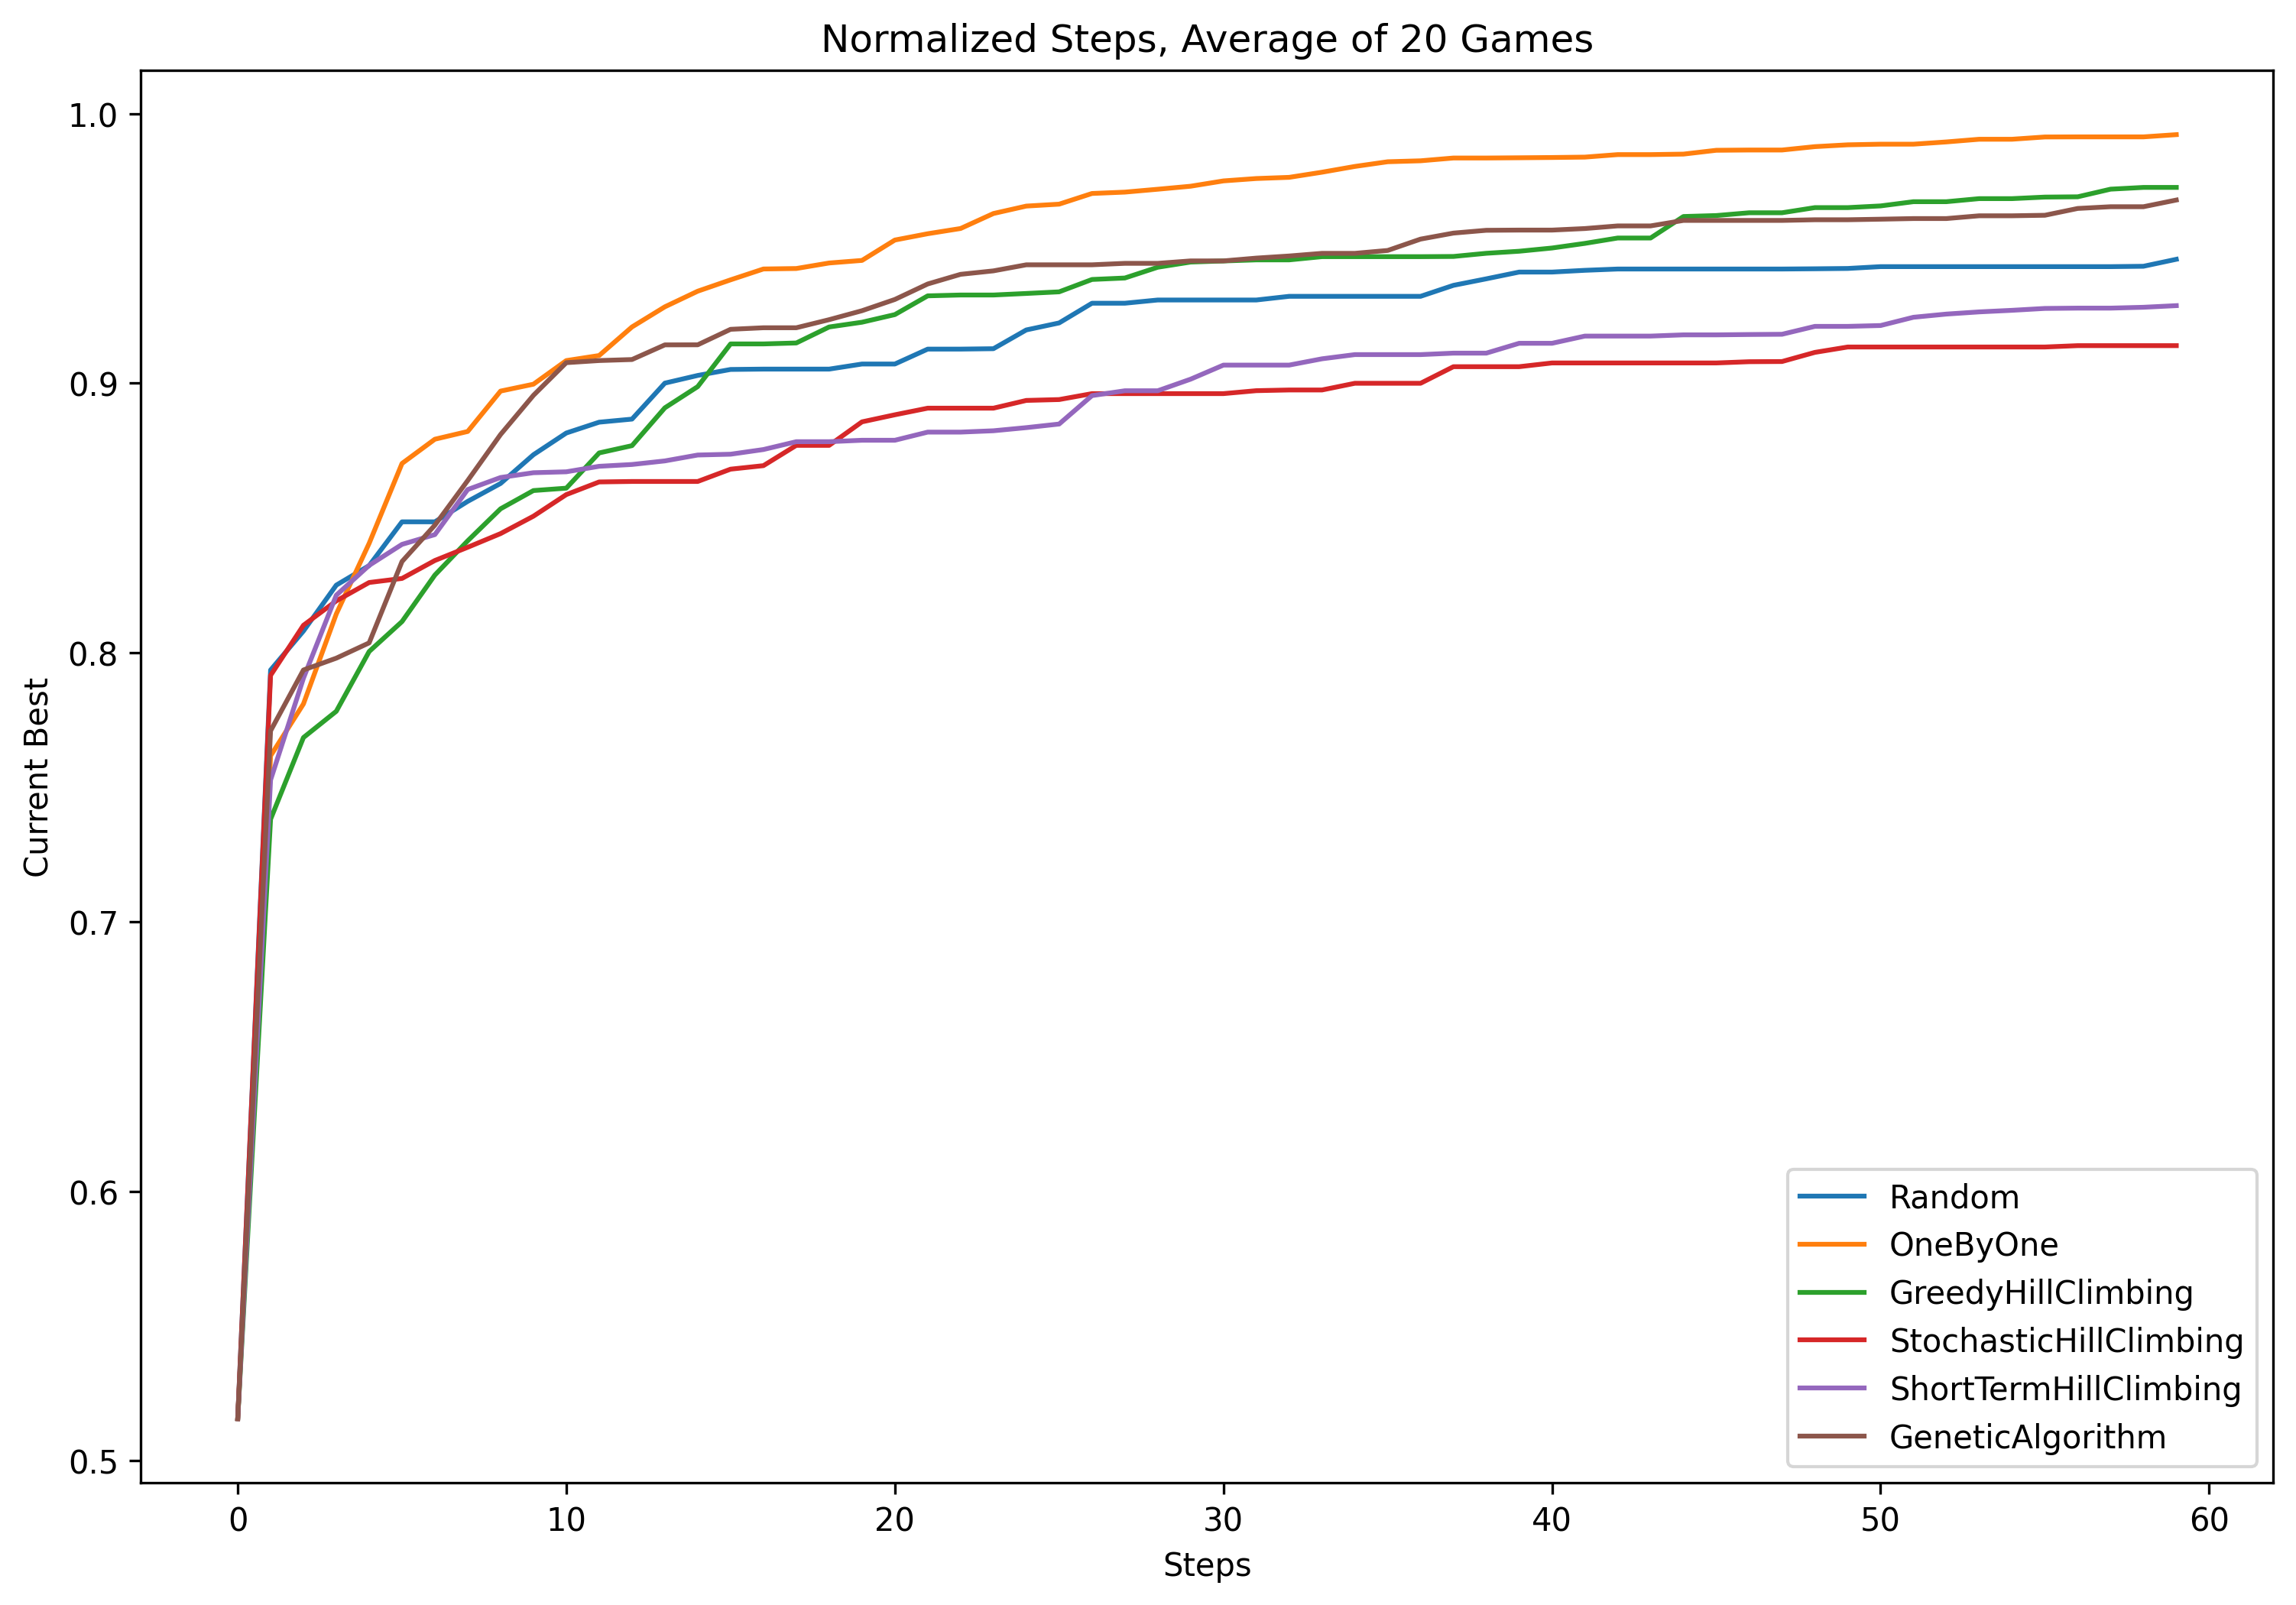

In [2]:
strategies = [Random, OneByOne, GreedyHillClimbing, StochasticHillClimbing, ShortTermHillClimbing, GeneticAlgorithm]

curves = {}

num_steps = 60
games = range(20, 40)
for game in games:
    values = []
    steps = {}
    starting_value = load_blosc2(f'random/{game}.blosc2').get_tries()[tuple(range(rules.num_batters))]
    for strategy in strategies:
        strat = load_blosc2(f'{strategy.__name__.lower()}/{game}.blosc2')
        values += list(strat.get_tries().values())
        step_arr = np.asarray([x[1] for x in strat.get_steps()])
        if len(step_arr) < num_steps:
            step_arr = np.pad(step_arr, (0, num_steps - len(step_arr)), 'constant', constant_values=step_arr[-1])
        step_arr.put(0, starting_value)
        steps[strategy] = step_arr
        
    minimum = min(values)
    maximum = max(values)
    for strategy in strategies:
        normalized = (steps[strategy] - minimum) / (maximum - minimum) / len(games)
        if strategy not in curves:
            curves[strategy] = normalized
        else:
            curves[strategy] += normalized

plt.figure(figsize=(12, 8), dpi=300)
for strategy in strategies:
    plt.plot(curves[strategy], label=strategy.__name__)

plt.xlabel('Steps')
plt.ylabel('Current Best')
plt.title('Normalized Steps, Average of 20 Games')
plt.legend()
plt.show()

# Measuring the Similarity of Game Rules
We can measure the similarity between the full Rules and the simplified DebugRules by comparing the relative evaluations of different lineups.

In [5]:
full_run = 'onebyone/cardinals_OPTIMAL.blosc2'  # Provide a run with the full rules
full_strat = load_blosc2(full_run)

generate_debug_run = False
debug_path = 'onebyone/cardinals_OPTIMAL_debug.blosc2'
if generate_debug_run:
    debug_tries = {}
    
    bd = BaseballData(load_pitches=False)
    average_pitcher = sum(p.data for p in bd.pitchers.values() if p.obp_percentile) / len(bd.pitchers)
    pitcher = Pitcher()
    pitcher.data = average_pitcher
    bd.pitchers['average_pitcher'] = pitcher
    cardinals = rosters['cardinals']
    match = ('average_pitcher', cardinals)
    
    solver = PolicySolver(bd, *match, rules=DebugRules)
    solver.initialize_distributions()
    for lineup in tqdm(full_strat.get_tries()):
        if lineup not in debug_tries:
            solver.set_batter_permutation(lineup)
            solver.calculate_optimal_policy(beta=2e-4, use_last_values=True)
            
            # Extract rotations
            for i in range(DebugRules.num_batters):
                value = solver.get_value(GameState(batter=i))
                idx = lineup.index(i)
                cycle_perm = tuple(lineup[idx:] + lineup[:idx])
                debug_tries[cycle_perm] = value
                
    save_blosc2(debug_tries, debug_path)
else:
    debug_tries = load_blosc2(debug_path)

In [16]:
def rank_data(data):
    sorted_data = sorted((e, i) for i, e in enumerate(data))
    ranks = [0] * len(data)
    for rank, (value, index) in enumerate(sorted_data, 1):
        ranks[index] = rank
    return ranks

keys = list(full_strat.get_tries().keys())
full_values = [full_strat.get_tries()[key] for key in keys]
debug_values = [debug_tries[key] for key in keys]

full_ranks = rank_data(full_values)
debug_ranks = rank_data(debug_values)

# Spearman's rank correlation 
n = len(full_values)
d = sum((full_ranks[i] - debug_ranks[i]) ** 2 for i in range(n))
1 - 6 * d / (n * (n ** 2 - 1))

0.86748289798187

# Testing on Real Batter Lineups
This part needs to be redone

Average real: 4.7397512641161805
Average improved: 4.785204138409004
Median improvement: 0.04098222692080489


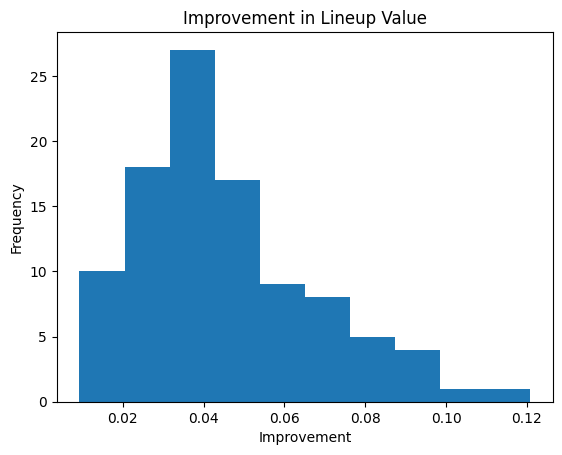

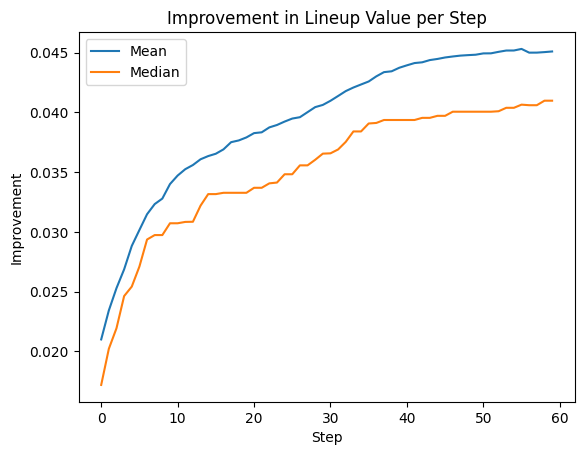

In [49]:
avg_real = 0
avg_improved = 0
improvements = []
improvements_per_step = []

trial_dir = 'lineups/'
trial_files = os.listdir(trial_dir)
for file in trial_files:
    strat = load_blosc2(f'{trial_dir}{file}')
    real_lineup_value = strat.get_tries()[tuple(range(rules.num_batters))]
    improved_lineup_value = strat.get_best()[1]
    for i, step in enumerate(strat.get_steps()):
        if i >= len(improvements_per_step):
            improvements_per_step.append([])
        improvements_per_step[i].append(step[1] - real_lineup_value)
    
    avg_real += real_lineup_value
    avg_improved += improved_lineup_value
    improvements.append(improved_lineup_value - real_lineup_value)
    
    
print(f'Average real: {avg_real / len(trial_files)}')
print(f'Average improved: {avg_improved / len(trial_files)}')
print(f'Median improvement: {np.median(improvements)}')

# Plot histogram of improvements
plt.hist(improvements)
plt.xlabel('Improvement')
plt.ylabel('Frequency')
plt.title('Improvement in Lineup Value')
plt.show()

# Plot improvement per step
plt.plot([np.mean(steps) for steps in improvements_per_step], label='Mean')
plt.plot([np.median(steps) for steps in improvements_per_step], label='Median')
plt.legend()
plt.xlabel('Step')
plt.ylabel('Improvement')
plt.title('Improvement in Lineup Value per Step')
plt.show()

# Optimizing the Cardinals

((0, 4, 5, 6, 1, 3, 7, 8, 2), 5.261660298357274)


KeyError: (0, 1, 2, 3, 4, 5, 6, 7, 8)

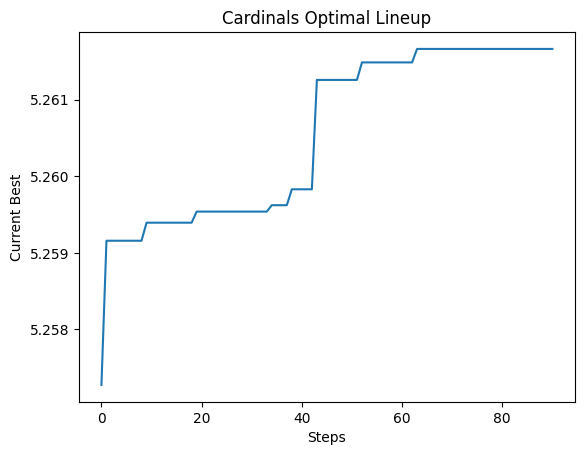

In [14]:
cardinals_optimal = load_blosc2('onebyone/average_test_alt_proper.blosc2')

plt.plot([s[1] for s in cardinals_optimal.get_steps()])
plt.xlabel('Steps')
plt.ylabel('Current Best')
plt.title('Cardinals Optimal Lineup')

print(cardinals_optimal.get_best())
print(cardinals_optimal.get_tries()[tuple(range(rules.num_batters))])